# Import

In [33]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, get_cosine_schedule_with_warmup, BertForSequenceClassification
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import FileLink
import pathlib
import re
import random

In [34]:
# Preparing for GPU usage
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [35]:
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

SEED = 2003807
set_seed(SEED)
DATA_DIR = pathlib.Path('/kaggle/input/dataset-for-ecom-t-and-dls-workshop/dataset')

# Data

## Loading

In [36]:
df_trends = pd.read_csv(DATA_DIR / "trends_description.csv", index_col='trend_id')
train = pd.read_csv(DATA_DIR / "train.csv", index_col='index').drop(columns='Unnamed: 0')
test = pd.read_csv(DATA_DIR / 'test.csv', index_col='index').drop(columns='Unnamed: 0')
train.head(3)

,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
index,,,,,,,,,,,,,,,,,,,,,
5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
target_cols = train.columns[-50:]
targets = train[target_cols].copy()

In [39]:

train.drop(columns=target_cols, inplace=True)

target_col = 'target'
targets.loc[:, target_col] = targets.apply(lambda row: list(row), axis=1)
targets.drop(columns=target_cols, inplace=True)

train[target_col] = targets
train.head(3)

,assessment,tags,text,target
index,,,,
5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Preprocessing

### NaN filling

In [40]:
def update_df(train, test):
    train = pd.concat((df.iloc[:train_idx], targets), axis='columns')
    test = df.iloc[train_idx:]
    return train, test

train_idx = train.shape[0]
df = pd.concat((train.drop(columns='target'), test), axis='rows')
df.fillna('', inplace=True)
df.head(3)

,assessment,tags,text
index,,,
5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортиме..."
18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро
13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается


### Text processing

In [41]:
df['tags'].values[0]

'{ASSORTMENT,PROMOTIONS,DELIVERY}'

In [42]:
df['tags'] = df['tags'].map(lambda x: x[1:-1].replace(',', ' '))

In [43]:
all_tags = set()
for t in df.tags.values:
    all_tags |= set(t.split())
    
all_tags = list(all_tags)
all_tags

['SUPPORT',
 'PRODUCTS_QUALITY',
 'PAYMENT',
 'DELIVERY',
 'PROMOTIONS',
 'CATALOG_NAVIGATION',
 'PRICE',
 'ASSORTMENT']

In [44]:
tag_translate = {
    'CATALOG_NAVIGATION': 'каталога товаров',
    'PRODUCTS_QUALITY': 'качество продуктов',
    'PAYMENT': 'платежный сервис',
    'DELIVERY': 'качество доставки',
    'ASSORTMENT': 'ассортимент товаров',
    'SUPPORT': 'поддержка',
    'PROMOTIONS': 'акции в магазине',
    'PRICE': 'цены на продукты',
}
def translate_tag(tag_set):
    for tag_en in tag_set.split():
        tag_set = tag_set.replace(tag_en, tag_translate[tag_en] + ',')
    return tag_set
df['tags_ru'] = df['tags'].apply(translate_tag)

In [45]:
symbs = set()
for t in df.text.values:
    symbs.update(set(t.lower()))

symbs = list(symbs)
symbs = ''.join(symbs)

trash_symbs = re.findall(r'\W|ツ', symbs)
trash_symbs = ''.join(trash_symbs).replace(' ', '')

pattern = f'[{re.escape(trash_symbs)}]'

# example
t = df['text'].iloc[12345]
t, ' '.join(re.sub(pattern, ' ', t).split())

('Было бы классно, если в ассортимент добавили сливки [NUM]% и улучшили обратную связь(службу поддержки клиентов).',
 'Было бы классно если в ассортимент добавили сливки NUM и улучшили обратную связь службу поддержки клиентов')

In [46]:
df['text'] = df['text'].map(
    lambda x: ' '.join(re.sub(pattern, ' ', x.lower()).split())
    )
df.head(3)

,assessment,tags,text,tags_ru
index,,,,
5652,6.0,ASSORTMENT PROMOTIONS DELIVERY,маленький выбор товаров хотелось бы ассортимен...,"ассортимент товаров, акции в магазине, качеств..."
18092,4.0,ASSORTMENT PRICE PRODUCTS_QUALITY DELIVERY,быстро,"ассортимент товаров, цены на продукты, качеств..."
13845,6.0,DELIVERY PROMOTIONS PRICE ASSORTMENT SUPPORT,доставка постоянно задерживается,"качество доставки, акции в магазине, цены на п..."


In [47]:
train, test = update_df(train, test)

## Dataset class

In [48]:
class EcomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, mode='train'):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['tags_ru'].str.cat(dataframe['text'], sep=' ') + \
        ' я ставлю оценку ' + dataframe['assessment'].astype(str)
        
        self.mode = mode
        if mode == 'train':
            self.targets = self.data.target
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text.iloc[index])

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        if self.mode == 'train':
            output = {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'targets': torch.tensor(self.targets[index], dtype=torch.float)
            }
        else:
            output = {
                'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            }
        return output

# Model

## Initialization

In [49]:
def model_init(model_name):
    NUM_CLASSES = len(train.target.iloc[0])

    bert_model = BertForSequenceClassification.from_pretrained(
        model_name, num_labels=NUM_CLASSES)
    
    bert_model.dropout = nn.Dropout(p=0.2)
    nn.init.xavier_uniform_(bert_model.classifier.weight)
    bert_model.classifier.bias.data.fill_(0)
    
    return bert_model.to(DEVICE)

## Train and valid func

In [50]:
def fit_linear(model, loader, criterion, optimizer, n_unfreeze=5):
    for param in model.bert.parameters():
        param.requires_grad = False
        
    model.train()
    torch.cuda.empty_cache()
    for data in tqdm(loader):
        ids = data['ids'].to(DEVICE, dtype=torch.long)
        mask = data['mask'].to(DEVICE, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
        labels = data['targets'].to(DEVICE, dtype=torch.float)
        
        optimizer.zero_grad()
        pred = model(ids, mask, token_type_ids).logits
        loss = criterion(pred, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
    for l in model.bert.encoder.layer[-n_unfreeze:]:
        for param in l.parameters():
            param.requires_grad = True
            
    for param in model.bert.pooler.dense.parameters():
        param.requires_grad = True

In [51]:
def train_epoch(model, loader, criterion, optimizer, scheduler=None):
    train_loss = 0

    model.train()
    for data in tqdm(loader):
        ids = data["ids"].to(DEVICE, dtype=torch.long)
        mask = data["mask"].to(DEVICE, dtype=torch.long)
        token_type_ids = data["token_type_ids"].to(DEVICE, dtype=torch.long)
        labels = data["targets"].to(DEVICE, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(ids, mask, token_type_ids).logits
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        if scheduler:
            scheduler.step()

        train_loss += loss.item()
    return train_loss / len(loader)

In [52]:
def eval_epoch(model, loader, criterion):
    val_loss = 0
    preds = []
    targets = []
    model.eval()
    for data in tqdm(loader):
        ids = data['ids'].to(DEVICE, dtype=torch.long)
        mask = data['mask'].to(DEVICE, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
        labels = data['targets'].to(DEVICE, dtype=torch.float)

        with torch.no_grad():
            outputs = model(ids, mask, token_type_ids).logits
            loss = criterion(outputs, labels)

        val_loss += loss.item()
        targets.append(labels)
        preds.append(torch.sigmoid(outputs))

    preds = torch.cat(preds, dim=0).cpu().detach().numpy()
    targets = torch.cat(targets, dim=0).cpu().detach().numpy()
    targets = np.array(targets)
    preds = (np.array(preds) >= 0.5).astype(int)
    
    return val_loss, accuracy_score(targets, preds)

In [53]:
def eval_treshhold(model, loader):
    preds = []
    targets = []
    model.eval()
    for data in tqdm(loader):
        ids = data['ids'].to(DEVICE, dtype=torch.long)
        mask = data['mask'].to(DEVICE, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)
        labels = data['targets'].to(DEVICE, dtype=torch.float)

        with torch.no_grad():
            outputs = model(ids, mask, token_type_ids).logits

        targets.append(labels)
        preds.append(torch.sigmoid(outputs))

    preds = torch.cat(preds, dim=0).cpu().detach().numpy()
    targets = torch.cat(targets, dim=0).cpu().detach().numpy()
    
    acc = []
    targets = np.array(targets)
    ths = np.arange(0.3, 0.8, 0.05)
    for th in ths:
        preds_ = (np.array(preds) >= th).astype(int)
        acc.append(accuracy_score(targets, preds_))
    max_acc = max(acc)
    print(f'best th = {ths[acc.index(max_acc)]}')
    print(max_acc)
    print(acc, ths)

In [54]:
def fit_model(model, train_loader, val_loader, criterion, optimizer,
              n_epoch, scheduler=None, best_model_path='bert_model.pt'):
    train_losses = []
    val_losses = []
    val_scores = []
    max_val_score = -1
    best_cnt = 0
    
    torch.cuda.empty_cache()
    for epoch in range(n_epoch):
        print(f'Training epoch {epoch + 1}')
        print('train:')
        train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler)
        torch.cuda.empty_cache()

        print('validation:')
        val_loss, val_score = eval_epoch(model, val_loader, criterion)
        torch.cuda.empty_cache()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_scores.append(val_score)
        
        if val_score > max_val_score:
            max_val_score = val_score
            torch.save(model.state_dict(), best_model_path)
            best_cnt = 0
        else:
            best_cnt += 1
        if best_cnt > 2:
            pass
            print("Loading best model weights!")
            model.load_state_dict(torch.load(best_model_path, weights_only=True))
            

        stats = f'train loss={train_loss:.6f}' + ' ' * 5
        stats += f'val loss={val_loss:.6f}' + '\n'
        stats += f'val score={val_score:.5f}'
        print()
        print(stats)
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
    return train_losses, val_losses, val_scores

## Dataloaders

In [55]:
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

In [56]:
train_size = 0.85
train_data = train.sample(frac=train_size, random_state=SEED)
val_data = train.drop(train_data.index).reset_index(drop=True)
train_data.reset_index(drop=True, inplace=True)

MAX_LEN = 300
train_set = EcomDataset(train_data, tokenizer, MAX_LEN)
val_set = EcomDataset(val_data, tokenizer, MAX_LEN)
test_set = EcomDataset(test, tokenizer, MAX_LEN, 'test')

BS = 16
train_loader = DataLoader(train_set, batch_size=BS, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BS, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BS, shuffle=False)

## Training

In [57]:
torch.cuda.empty_cache()

In [58]:
model = model_init(MODEL_NAME)
criterion = nn.BCEWithLogitsLoss()
optimizer_l = torch.optim.Adam(params=model.parameters(), lr=5e-6)
fit_linear(model, train_loader, criterion, optimizer_l, n_unfreeze=8)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 246/246 [00:35<00:00,  6.83it/s]


In [59]:
N_EPOCHS = 30
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-5)
scheduler = get_cosine_schedule_with_warmup(
                optimizer,
                num_warmup_steps=len(train_loader) * 1,
                num_training_steps=len(train_loader) * N_EPOCHS,
                num_cycles=0.4
            )


In [60]:
train_losses, val_losses, val_scores = fit_model(model, train_loader, val_loader,
                                                 criterion, optimizer, N_EPOCHS, scheduler)

Training epoch 1
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.25it/s]



train loss=0.215210     val loss=4.577987
val score=0.00000
Training epoch 2
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.23it/s]



train loss=0.090898     val loss=3.169817
val score=0.33333
Training epoch 3
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.23it/s]



train loss=0.066918     val loss=2.578929
val score=0.45743
Training epoch 4
train:


100%|██████████| 246/246 [01:35<00:00,  2.59it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.26it/s]



train loss=0.053764     val loss=2.319058
val score=0.47475
Training epoch 5
train:


100%|██████████| 246/246 [01:35<00:00,  2.59it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.26it/s]



train loss=0.043130     val loss=2.184902
val score=0.47908
Training epoch 6
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.24it/s]



train loss=0.034996     val loss=2.295589
val score=0.50361
Training epoch 7
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.24it/s]



train loss=0.027673     val loss=2.124038
val score=0.51659
Training epoch 8
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.25it/s]



train loss=0.022398     val loss=2.168812
val score=0.52237
Training epoch 9
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.23it/s]



train loss=0.018458     val loss=2.205584
val score=0.52237
Training epoch 10
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.27it/s]



train loss=0.014643     val loss=2.290572
val score=0.53824
Training epoch 11
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.24it/s]



train loss=0.012050     val loss=2.383495
val score=0.52814
Training epoch 12
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.22it/s]



train loss=0.010259     val loss=2.297727
val score=0.53102
Training epoch 13
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.24it/s]


Loading best model weights!

train loss=0.008587     val loss=2.394983
val score=0.53680
Training epoch 14
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.24it/s]



train loss=0.011624     val loss=2.333975
val score=0.55123
Training epoch 15
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.25it/s]



train loss=0.009246     val loss=2.340252
val score=0.53968
Training epoch 16
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.23it/s]



train loss=0.007650     val loss=2.447803
val score=0.53247
Training epoch 17
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.24it/s]


Loading best model weights!

train loss=0.006307     val loss=2.511369
val score=0.52525
Training epoch 18
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.24it/s]


Loading best model weights!

train loss=0.008721     val loss=2.305170
val score=0.51948
Training epoch 19
train:


100%|██████████| 246/246 [01:35<00:00,  2.56it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.22it/s]


Loading best model weights!

train loss=0.008829     val loss=2.305972
val score=0.53680
Training epoch 20
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.21it/s]


Loading best model weights!

train loss=0.008665     val loss=2.347932
val score=0.52670
Training epoch 21
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.22it/s]


Loading best model weights!

train loss=0.008572     val loss=2.345230
val score=0.54690
Training epoch 22
train:


100%|██████████| 246/246 [01:36<00:00,  2.56it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.21it/s]


Loading best model weights!

train loss=0.008679     val loss=2.320870
val score=0.53102
Training epoch 23
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.20it/s]


Loading best model weights!

train loss=0.008425     val loss=2.281481
val score=0.53535
Training epoch 24
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.23it/s]


Loading best model weights!

train loss=0.008115     val loss=2.274758
val score=0.54257
Training epoch 25
train:


100%|██████████| 246/246 [01:35<00:00,  2.56it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.22it/s]


Loading best model weights!

train loss=0.008297     val loss=2.267864
val score=0.54401
Training epoch 26
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.23it/s]


Loading best model weights!

train loss=0.008279     val loss=2.261847
val score=0.53102
Training epoch 27
train:


100%|██████████| 246/246 [01:35<00:00,  2.56it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.25it/s]


Loading best model weights!

train loss=0.008051     val loss=2.248177
val score=0.53680
Training epoch 28
train:


100%|██████████| 246/246 [01:35<00:00,  2.56it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.23it/s]


Loading best model weights!

train loss=0.008199     val loss=2.230014
val score=0.53824
Training epoch 29
train:


100%|██████████| 246/246 [01:35<00:00,  2.57it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.22it/s]


Loading best model weights!

train loss=0.008200     val loss=2.253486
val score=0.53535
Training epoch 30
train:


100%|██████████| 246/246 [01:35<00:00,  2.56it/s]


validation:


100%|██████████| 44/44 [00:07<00:00,  6.20it/s]


Loading best model weights!

train loss=0.008291     val loss=2.222949
val score=0.53391


In [61]:
eval_treshhold(model, val_loader)

100%|██████████| 44/44 [00:06<00:00,  7.20it/s]


best th = 0.44999999999999996
0.5512265512265512
[0.5165945165945166, 0.5295815295815296, 0.5425685425685426, 0.5512265512265512, 0.5512265512265512, 0.5483405483405484, 0.5382395382395382, 0.5396825396825397, 0.5367965367965368, 0.5324675324675324] [0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75]


In [62]:
if scheduler:
    print(scheduler.get_lr())

[4.7745751406263165e-06]


0.5512265512265512


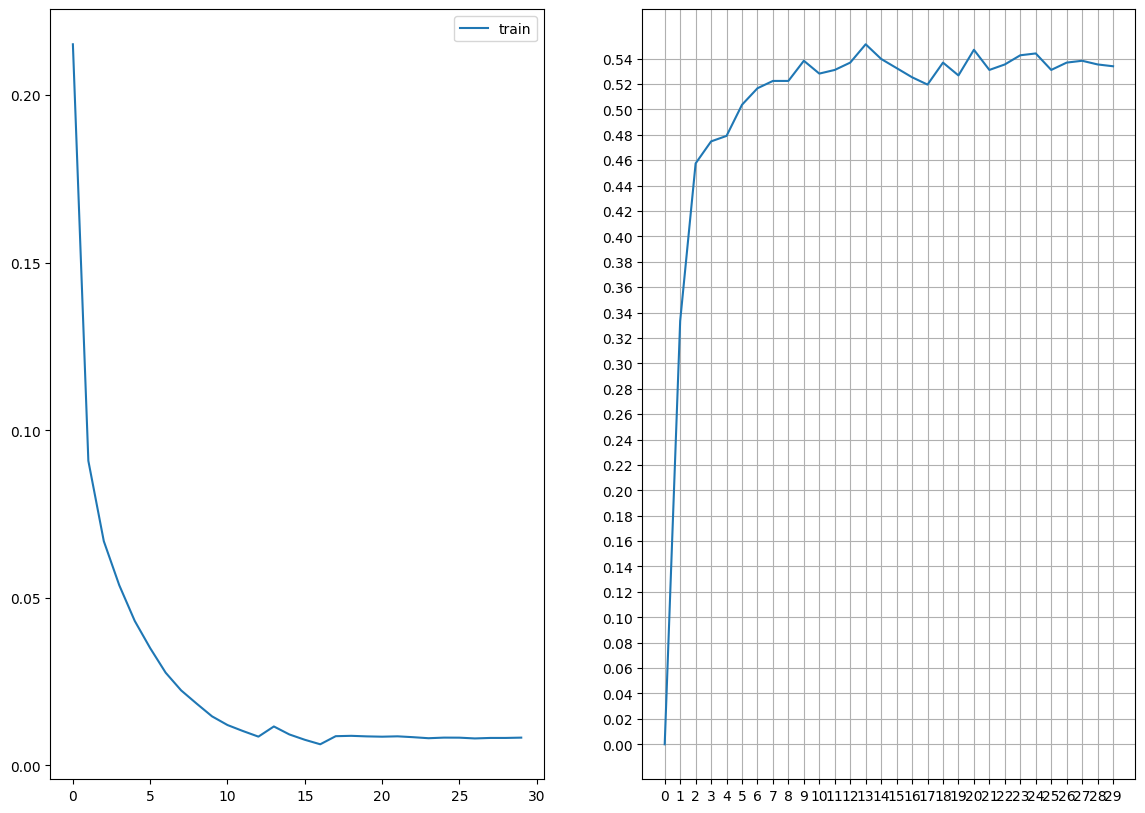

In [63]:
print(max(val_scores))
plt.figure(figsize=(14, 10))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.legend()

plt.subplot(1, 2 ,2)
plt.plot(val_scores, label='validation')
plt.xticks(range(N_EPOCHS))
plt.yticks(np.arange(0, max(val_scores), 0.02))
plt.grid()

plt.show()

# Testing

In [65]:
def test_model(model, loader, is_proba=False, th=0.5):
    preds = []
    model.eval()
    for data in tqdm(loader):
        ids = data['ids'].to(DEVICE, dtype=torch.long)
        mask = data['mask'].to(DEVICE, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(DEVICE, dtype=torch.long)

        with torch.no_grad():
            outputs = model(ids, mask, token_type_ids).logits
        preds.append(torch.sigmoid(outputs))
    
    preds = torch.cat(preds, dim=0).cpu().detach().numpy()
    if is_proba:
        return preds
    return (np.array(preds) >= th).astype(int)

def trg_to_sub(t, indx=None):
    t = np.array(t)
    indx = range(t.shape[0]) if indx is None else indx
    target_values = []
    for row in t:
        non_zero_indices = np.nonzero(np.array(row))[0]
        if non_zero_indices.size > 0:
            target_values.append(' '.join(map(str, non_zero_indices)))
        else:
            target_values.append(np.nan)
    return pd.DataFrame({'target': target_values}, index=indx)

In [66]:
th = 0.5
model.load_state_dict(torch.load('bert_model.pt', weights_only=True))
preds = test_model(model, test_loader, th=th)

100%|██████████| 564/564 [01:19<00:00,  7.09it/s]


In [67]:
sub = trg_to_sub(preds, indx=test.index)
sub.head()

,target
index,
3135,1 2 8 12 36
4655,12
22118,2
23511,0
45,18


In [68]:
sub_fn = f'sub_bert_{max(val_scores):.4f}_{th}_{SEED}.csv'

sub.to_csv(sub_fn)
display(FileLink(sub_fn))

/kaggle/working/sub_bert_0.5512_0.5_2003807.csv